# Imports

In [2]:
# stdlib
import re
import copy
import random
import itertools
import statistics
import multiprocessing

# data wrangling
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# custom
from hotspot_classes import Hotspot
import hotspot_utils

# Set the number of processors to use for parallel processing
n_processors = max([1,multiprocessing.cpu_count()-2])

# Read in the insults list
with open('insults.txt', 'r') as f:
    insults = f.read().splitlines()

# Reading data - Works for single or double file layouts

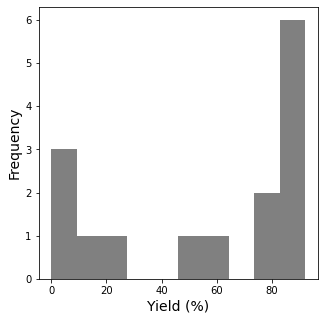

,Yield (%),#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol MW,...,%Vbur_C_SF_4.0Å,%Vbur_S_4.0Å,Sterimol_B1_S_C_SF(Å)_morfeus,Sterimol_B1_S_F(Å)_morfeus,Sterimol_B5_S_C_SF(Å)_morfeus,Sterimol_B5_S_F(Å)_morfeus,Sterimol_L_S_C_SF(Å)_morfeus,Sterimol_L_S_F(Å)_morfeus,pyramidalization_Agranat-Radhakrishnan_S,pyramidalization_Gavrish_S(°)
ID,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,1,1,0,174.190,...,54.844128,42.157532,2.137894,2.094727,3.249804,7.651505,8.141081,3.481289,0.697372,5.113179
8,83,2,0,0,0,0,1,1,0,161.151,...,53.226833,40.672134,2.112131,2.080162,3.305270,6.598246,7.059489,3.474909,0.679960,4.945324
25,0,3,0,0,0,0,2,1,-1,185.173,...,54.920551,42.088092,2.002186,2.081257,3.253081,8.576403,9.064231,3.476997,0.682768,4.984751
66,75,1,0,0,0,0,1,1,0,190.192,...,54.388306,39.354711,2.452904,2.073022,4.365122,7.045309,7.004848,3.577247,0.673382,4.890250
82,83,5,0,0,0,0,1,1,-1,162.138,...,51.527683,39.299237,2.293044,2.067147,3.262547,6.564698,7.022008,3.472780,0.666606,4.833776
93,0,3,0,0,0,0,2,2,0,218.199,...,61.676029,48.317144,2.124897,2.098155,5.947959,6.520619,7.114192,4.108705,0.698627,5.100261
4005,22,0,0,0,0,0,2,1,0,290.311,...,53.298988,40.680668,2.367618,2.086159,4.160174,13.101572,13.564332,3.477162,0.686995,5.007417
1826,83,3,0,0,0,0,1,1,-1,216.190,...,59.176184,45.406865,2.180693,2.077052,5.449503,6.652710,6.581678,3.745162,0.678841,4.950956
1827,92,2,0,0,0,0,1,1,0,216.190,...,56.158448,41.597744,2.322078,2.066912,5.266961,8.063378,7.990175,3.840471,0.667290,4.839725


In [4]:
# This cell assumes that your spreadsheets are in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# vs_parameters_header_rows and vs_parameters_start_col variables.
# Check cell outputs to make sure everything looks good

parameters_file = "Scope_descriptors" # Excel file to pull parameters from
parameters_sheet = "training" # Sheet in the Excel file to pull parameters from
parameters_start_col = 3   # 0-indexed column number where the parameters start
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "Scope_descriptors" # Excel file to pull responses from
response_sheet = "training" # Sheet in the Excel file to pull responses from
response_col = 2 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 0 # Number of rows to skip when reading the responses

RESPONSE_LABEL = "Yield (%)" # Name of your response variable

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.rename(columns = {data_df.columns.values[0]: RESPONSE_LABEL}, inplace = True) # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # Remove any rows with blanks

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Get a list of all the features
all_features = list(data_df.columns)
all_features.remove(RESPONSE_LABEL)

# Check for duplicate reaction labels or column names
error = False
if len(list(data_df.index)) != len(list(set(data_df.index))):
    print('THERE ARE DUPLICATE REACTION LABELS IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True
if len(list(data_df.columns)) != len(list(set(data_df.columns))):
    print('THERE ARE DUPLICATE COLUMN NAMES IN THE DATA. PLEASE CORRECT THIS IN YOUR SPREADSHEET.')
    error = True

if not error:
    # Print out the data distribution of the response variable
    plt.figure(figsize=(5, 5))
    plt.hist(data_df[RESPONSE_LABEL], color='grey')
    plt.xlabel(RESPONSE_LABEL, fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.show()

    # Display the dataframe
    display(data_df)

# Threshold Analysis

## Train / Test split

Training Set: [0, 8, 25, 66, 82, 93, 4005, 1826, 1827, 3394, 3401, 4007]
Validation Set: []
Test Set: [2921, 3387, 3407]

Training Set size: 12
Validation Set size: 0
Test Set size: 3

Training Set mean: 55.250
Validation Set mean: nan
Test Set mean: 52.000


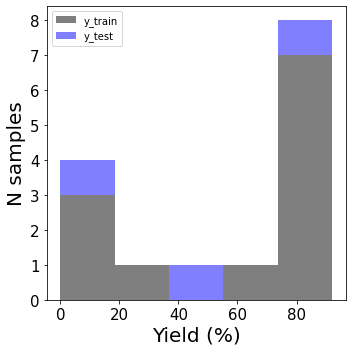

In [5]:
# Split options are 'random', 'ks', 'y_equidistant', 'stratified', 'define', 'none'

# Core options
split = "y_equidistant"
test_ratio = 0.2 

# Less common parameters
stratified_quantiles = 10 # Number of quantiles to split the data into for stratified sampling
defined_training_set = [] # If you want to manually define the training set, put the list of points here
defined_test_set = [] # If you want to manually define the test set, put the list of points here
randomstate = 42 # Random state for reproducibility

# --------------------------------------------------------------------------------------------------------------
training_set, validation_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, all_features, RESPONSE_LABEL,
                                                        defined_test_set=defined_test_set, defined_training_set=defined_training_set,
                                                        randomstate=randomstate, stratified_quantiles=stratified_quantiles)

## Automatic Threshold Analysis

In [6]:
# Cutoff in your output for what counts as an active ligand
y_cut = 25

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands (1) over inactive ligands (0)
class_weight = {1:1, 0:1} 

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'accuracy'

# How many threshold dimensions do you want?
n_thresholds = 1

# What percentage of thresholds are analyzed in each subsequent step
percentage = 100

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, all_features)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with multiprocessing.Pool(processes=int(n_processors-2)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, itertools.repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:1]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

Hotspot Index: 0
Total accuracy with 1 thresholds: 1.000
Initial accuracy with no thresholds: 0.667
Total accuracy with 1 thresholds: 1.000
Initial accuracy with no thresholds: 0.667
Thresholds: 
	distance_C_SF_S(Å) > 1.789 with Added accuracy of 0.333

                    all    train    test
         Accuracy: 1.000   1.000   1.000
Weighted Accuracy: 1.000   1.000   1.000
               F1: 1.000   1.000   1.000
      Weighted F1: 1.000   1.000   1.000

        Precision: 1.000
           Recall: 1.000

**********************************



## Visualize Thresholds

Total accuracy with 1 thresholds: 1.000
Initial accuracy with no thresholds: 0.667
Total accuracy with 1 thresholds: 1.000
Initial accuracy with no thresholds: 0.667
Thresholds: 
	distance_C_SF_S(Å) > 1.789 with Added accuracy of 0.333



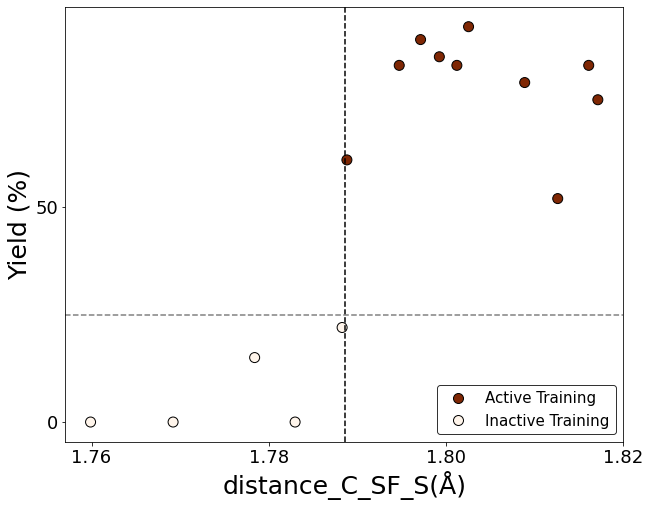

In [7]:
# For more direct control over plot style, changes can be made to the plotting functions in hotsput_utils.py
# One of the above functions must be run before this cell can ran
hotspot_index =  0
print(best_hotspots[hotspot_index])

# subset can be 'all', 'training', or 'test'
# You can change the coloring to either 'scaled' or 'binary'
hotspot_utils.plot_hotspot(best_hotspots[hotspot_index], 
                            subset='all', 
                            coloring='binary', 
                            output_label=RESPONSE_LABEL,
                            gradient_color='Oranges')

# Virtual Screening / Validation

## Import Virtual Screening / Validation Parameter Data

This cell must be executed before any other validation or virtual screening cells

In [9]:
# This cell assumes that your spreadsheet is in .xlsx format and that there are no columns after the parameters
# or rows after the last reaction. Extra rows and columns before the data are fine and can be skipped with the
# vs_parameters_header_rows and vs_parameters_start_col variables.

vs_parameters_file = "Scope_descriptors" # Excel file to pull parameters from
vs_parameters_sheet = "validation" # Sheet in the Excel file to pull parameters from
vs_parameters_start_col = 3   # 0-indexed column number where the parameters start
vs_parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
vs_parameters_header_rows = 0 # Number of rows to skip when reading the parameters. First row should be parameter names.

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into a dataframe
vs_parameters_df = pd.read_excel("./InputData/" + vs_parameters_file + ".xlsx",
                              vs_parameters_sheet,
                              header = vs_parameters_header_rows,
                              index_col = vs_parameters_y_label_col,
                              )

# Skip any columns that are not parameters
vs_parameters_df = vs_parameters_df.iloc[:,vs_parameters_start_col-1:]

# Check that all parameters from the original dataset are present and put them in the same order
try:
  vs_parameters_df = vs_parameters_df[all_features]
except KeyError:
  print('There are features in the main dataset that are not present in this parameter file.')
  print('If your model was built with scaled features, this will cause an error downstream.')

  # If any parameters are missing, at least remove all columns that are not in the original dataset
  columns_to_keep = [col for col in vs_parameters_df.columns if col in all_features]
  vs_parameters_df = vs_parameters_df[columns_to_keep]

# Display the dataframe
display(vs_parameters_df)

,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol MW,dipole,...,%Vbur_C_SF_4.0Å,%Vbur_S_4.0Å,Sterimol_B1_S_C_SF(Å)_morfeus,Sterimol_B1_S_F(Å)_morfeus,Sterimol_B5_S_C_SF(Å)_morfeus,Sterimol_B5_S_F(Å)_morfeus,Sterimol_L_S_C_SF(Å)_morfeus,Sterimol_L_S_F(Å)_morfeus,pyramidalization_Agranat-Radhakrishnan_S,pyramidalization_Gavrish_S(°)
ID,,,,,,,,,,,,,,,,,,,,,
4001,0,0,0,0,0,1,1,0,277.270,7.686,...,53.212479,40.658556,2.198109,2.082400,3.779647,12.498052,12.992998,3.475858,0.682595,4.969944
4002,0,0,0,0,0,1,1,0,293.330,8.481,...,53.229548,40.651186,2.364902,2.081193,3.626743,12.791227,13.209226,3.475332,0.681687,4.961497
4003,0,0,0,0,0,3,1,0,280.316,8.746,...,53.323816,40.659720,2.411820,2.085303,6.028520,11.826696,12.079807,3.476272,0.685298,4.992039
4004,0,0,0,0,0,2,1,0,295.285,8.733,...,53.286962,40.666703,2.126236,2.084823,3.857127,12.880626,13.352138,3.476319,0.684931,4.989343
4006,1,0,0,0,0,2,2,-1,219.187,4.943,...,53.246229,40.663599,2.123919,2.075796,3.636654,9.670461,9.962191,3.473608,0.675748,4.908855
3410,1,0,0,0,0,1,1,0,217.233,7.016,...,53.437093,40.480495,2.079535,2.061988,3.896960,8.489213,8.980124,3.471123,0.663207,4.815745
4008,0,0,0,0,0,2,1,0,191.177,6.979,...,53.216746,40.690367,2.075651,2.085350,3.322190,8.691355,9.078362,3.477371,0.686533,5.005924
4009,1,0,0,0,0,2,1,-1,214.214,9.045,...,59.931103,44.325694,2.643302,2.067855,5.073953,6.889899,7.221106,3.970766,0.666400,4.823589
1778,1,0,0,0,0,1,1,0,241.240,9.724,...,55.407796,42.862020,2.218154,2.069441,5.470605,10.122740,9.876973,3.834689,0.671470,4.889403


## Validation

In [10]:
# Run this cell before the specific validation cells to set up the validation dataframe
# Read the validation results from the excel sheet
# The final result should be a dataframe with indicies corresponding to the vs_parameters_df from above,
# a column of experimental outputs, and all the relevant parameters

validation_file = "Scope_descriptors" # Excel file to pull validation results from
validation_sheet = "validation" # Sheet in the Excel file to pull validation results from
validation_response_col = 2 # 0-indexed column number for the experimental output
validation_y_label_col = 0  # 0-indexed column number where the ligand labels are
validation_header_rows = 0 # Number of rows to skip when reading the responses

############################################################################################################

vs_response_df = pd.read_excel('./InputData/' + validation_file + '.xlsx',
                              sheet_name=validation_sheet,
                              header=validation_header_rows,
                              index_col=validation_y_label_col
                              )

# Drop all columns except the experimental output
vs_response_df = vs_response_df.iloc[:, [validation_response_col-1]]
vs_response_df.columns = [RESPONSE_LABEL]

for column in vs_response_df.columns:
    vs_response_df[column] = pd.to_numeric(vs_response_df[column], errors='coerce')
vs_response_df.dropna(inplace = True)

vs_combined_df = pd.concat([vs_response_df, vs_parameters_df], axis=1, join='inner')

display(vs_combined_df)

,Yield (%),#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol MW,...,%Vbur_C_SF_4.0Å,%Vbur_S_4.0Å,Sterimol_B1_S_C_SF(Å)_morfeus,Sterimol_B1_S_F(Å)_morfeus,Sterimol_B5_S_C_SF(Å)_morfeus,Sterimol_B5_S_F(Å)_morfeus,Sterimol_L_S_C_SF(Å)_morfeus,Sterimol_L_S_F(Å)_morfeus,pyramidalization_Agranat-Radhakrishnan_S,pyramidalization_Gavrish_S(°)
ID,,,,,,,,,,,,,,,,,,,,,
4001,66,0,0,0,0,0,1,1,0,277.270,...,53.212479,40.658556,2.198109,2.082400,3.779647,12.498052,12.992998,3.475858,0.682595,4.969944
4002,69,0,0,0,0,0,1,1,0,293.330,...,53.229548,40.651186,2.364902,2.081193,3.626743,12.791227,13.209226,3.475332,0.681687,4.961497
4003,60,0,0,0,0,0,3,1,0,280.316,...,53.323816,40.659720,2.411820,2.085303,6.028520,11.826696,12.079807,3.476272,0.685298,4.992039
4004,71,0,0,0,0,0,2,1,0,295.285,...,53.286962,40.666703,2.126236,2.084823,3.857127,12.880626,13.352138,3.476319,0.684931,4.989343
4006,84,1,0,0,0,0,2,2,-1,219.187,...,53.246229,40.663599,2.123919,2.075796,3.636654,9.670461,9.962191,3.473608,0.675748,4.908855
3410,19,1,0,0,0,0,1,1,0,217.233,...,53.437093,40.480495,2.079535,2.061988,3.896960,8.489213,8.980124,3.471123,0.663207,4.815745
4008,0,0,0,0,0,0,2,1,0,191.177,...,53.216746,40.690367,2.075651,2.085350,3.322190,8.691355,9.078362,3.477371,0.686533,5.005924
4009,83,1,0,0,0,0,2,1,-1,214.214,...,59.931103,44.325694,2.643302,2.067855,5.073953,6.889899,7.221106,3.970766,0.666400,4.823589
1778,79,1,0,0,0,0,1,1,0,241.240,...,55.407796,42.862020,2.218154,2.069441,5.470605,10.122740,9.876973,3.834689,0.671470,4.889403


### Threshold Validation

Accuracy: 0.89
Precision: 1.00
Recall: 0.86


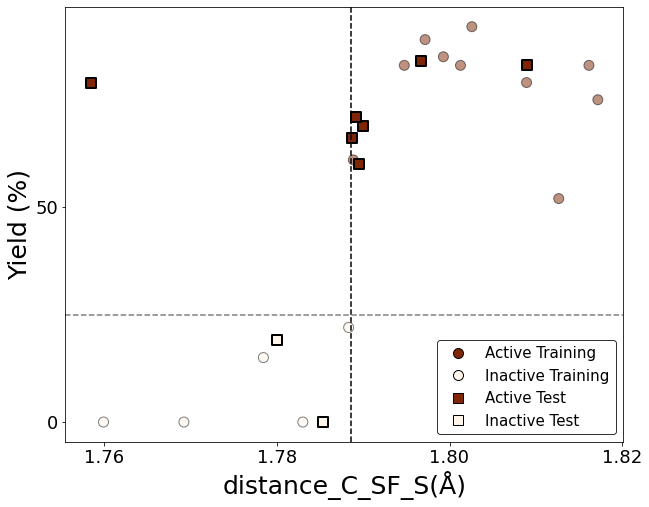

,distance_C_SF_S(Å)
ID,
4001,True
4002,True
4003,True
4004,True
4006,True
3410,False
4008,False
4009,True
1778,False


In [11]:
# Select hotspot to validate
hotspot_index = 0

# Set to True if you want to see only the virtual screen results plotted
hide_training = False

save_evaluation = False # Set to True if you want to save the threshold evaluation to an Excel file in the OutputData folder
save_filename = "threshold_evaluation" # Name of the Excel file to save the threshold evaluation to if save_evaluation is True

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN hotspot_utils.plot_hotspot(...)
# --------------------------------------------------------------------------------------------------------------

hs = best_hotspots[hotspot_index]

# Evaluate each validation point on each threshold
threshold_evaluations = hs.expand(vs_combined_df)

# Get validation stats and display the hotspot
hs.get_external_accuracy(vs_combined_df, RESPONSE_LABEL, verbose=True)
hotspot_utils.plot_hotspot(hs, vs_combined_df, vs_parameters_df, coloring='binary', output_label=RESPONSE_LABEL, hide_training=hide_training)

# Display the threshold evaluations
# True means the point is in on the active side of that threshold
display(threshold_evaluations)

# Save the threshold evaluations to an Excel file if requested
if save_evaluation:
    threshold_evaluations.to_excel("./OutputData/" + save_filename + ".xlsx")